<a href="https://colab.research.google.com/github/KudratBatta/Heart-Disease-Prediction/blob/main/Heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install ucimlrepo

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For optional EDA if uncommented
from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [45]:
heart_disease = fetch_ucirepo(id=45)

# Extract features (X) and targets (y)
X = heart_disease.data.features
y = heart_disease.data.targets

In [46]:
y = (y > 0).astype(int)
y.columns = ['target'] # Rename for clarity

print("First 5 rows of features (X):")
print(X.head())
print("\nFirst 5 rows of target (y):")
print(y.head())
print(f"\nShape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

First 5 rows of features (X):
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  

First 5 rows of target (y):
   target
0       0
1       1
2       1
3       0
4       0

Shape of X: (303, 13)
Shape of y: (303, 1)


In [47]:
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

for col in ['ca', 'thal']:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Median for numerical to be robust to outliers
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Mode for categorical
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Handles new categories in test set
])

/tmp/ipython-input-47-4031020858.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = pd.to_numeric(X[col], errors='coerce')


In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\nData splitting and preprocessing pipeline defined.")



Data splitting and preprocessing pipeline defined.


In [49]:
# Define the K-Nearest Neighbors model
knn_model = KNeighborsClassifier()

# Define hyperparameter distributions for RandomizedSearchCV
# These ranges are chosen to explore a good variety of KNN configurations.
knn_param_distributions = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21], # Number of neighbors
    'classifier__weights': ['uniform', 'distance'], # Weight function used in prediction
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'] # Distance metric
}

# Create the pipeline for KNN
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', knn_model)])

print("\n--- Starting Hyperparameter Tuning for K-Nearest Neighbors (using RandomizedSearchCV) ---")


--- Starting Hyperparameter Tuning for K-Nearest Neighbors (using RandomizedSearchCV) ---


In [50]:
random_search_knn = RandomizedSearchCV(knn_pipeline, knn_param_distributions, n_iter=50,
                                       cv=5, scoring='accuracy', n_jobs=-1,
                                       verbose=1, random_state=42)

random_search_knn.fit(X_train, y_train.values.ravel())

# Get the best estimator and its parameters
best_knn_model_pipeline = random_search_knn.best_estimator_
best_knn_params = random_search_knn.best_params_
best_knn_cv_score = random_search_knn.best_score_

print(f"\nBest Parameters for K-Nearest Neighbors: {best_knn_params}")
print(f"Cross-Validation Accuracy on Training Set: {best_knn_cv_score:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters for K-Nearest Neighbors: {'classifier__weights': 'distance', 'classifier__n_neighbors': 7, 'classifier__metric': 'euclidean'}
Cross-Validation Accuracy on Training Set: 0.8263


In [51]:
print("\n--- Evaluating the Tuned K-Nearest Neighbors Model on Test Set ---")

y_pred_knn = best_knn_model_pipeline.predict(X_test)
y_proba_knn = best_knn_model_pipeline.predict_proba(X_test)[:, 1]

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)

print(f"Test Accuracy: {accuracy_knn:.4f}")
print(f"Test Precision: {precision_knn:.4f}")
print(f"Test Recall: {recall_knn:.4f}")
print(f"Test F1-Score: {f1_knn:.4f}")
print(f"Test ROC-AUC: {roc_auc_knn:.4f}")


--- Evaluating the Tuned K-Nearest Neighbors Model on Test Set ---
Test Accuracy: 0.9016
Test Precision: 0.8667
Test Recall: 0.9286
Test F1-Score: 0.8966
Test ROC-AUC: 0.9643


In [52]:
print(f"\nClassification Report for Tuned K-Nearest Neighbors:\n{classification_report(y_test, y_pred_knn)}")
print(f"\nConfusion Matrix for Tuned K-Nearest Neighbors:\n{confusion_matrix(y_test, y_pred_knn)}")


Classification Report for Tuned K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        33
           1       0.87      0.93      0.90        28

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61


Confusion Matrix for Tuned K-Nearest Neighbors:
[[29  4]
 [ 2 26]]


In [53]:
print("\n--- Retraining the Best K-Nearest Neighbors Model on the Full Dataset ---")
final_trained_knn_model = best_knn_model_pipeline # Start with the best pipeline
final_trained_knn_model.fit(X, y.values.ravel()) # Retrain on the entire dataset

print(f"\nFinal Trained K-Nearest Neighbors Model Pipeline:\n{final_trained_knn_model}")


--- Retraining the Best K-Nearest Neighbors Model on the Full Dataset ---

Final Trained K-Nearest Neighbors Model Pipeline:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                          

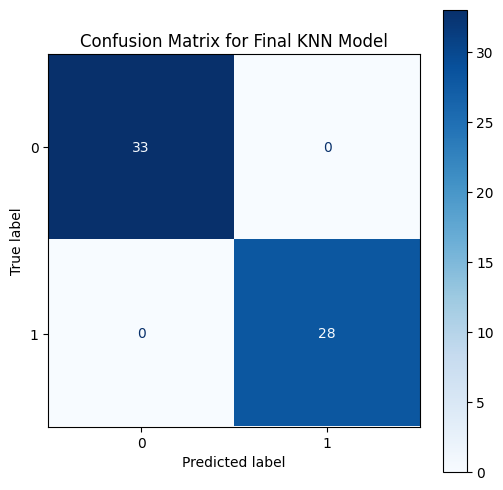

In [58]:
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(final_trained_knn_model, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for Final KNN Model')
plt.show()